In [1]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/model/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 42
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=64
DROPOUT=0.25
LEARNING_RATE=0.00001
CLASSIFICATION_RATIO=0.95

In [3]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [4]:
filenames = list(glob.glob('/tf/data/ADReSS-IS2020/Full_wave_enhanced_audio/*/*'))
random.shuffle(filenames)

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv('/tf/data/ADReSS-IS2020/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv('/tf/data/ADReSS-IS2020/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()

In [6]:
def getData(filename): 
    
    examples = vggish_input.wavfile_to_examples(filename)
    
    id = filename.split("/")[-1].split(".")[0]
    data = meta[meta["ID"]==id].iloc[0]
    
    mmse = [data["MMSE"] for i in range(examples.shape[0])]
    classes = [1 if data["Group"] == "cd" else 0 for i in range(examples.shape[0])]
    
    return examples, mmse, classes

def createDataset(files):
    
    allExamples = []
    allMMSE = []
    allClasses = []
    
    for filename in files:
        examples, mmse, classes = getData(filename)
        allExamples.append(examples)
        allMMSE.extend(mmse)
        allClasses.extend(classes)
    
    return tf.data.Dataset.from_tensor_slices((
        np.expand_dims(np.vstack(allExamples), axis=-1), 
        {
            "mmse": np.array(allMMSE),
            "classification": np.array(allClasses).reshape((-1,1))
        }
    ))

In [7]:
train_ds = createDataset(train_files).shuffle(1000)
val_ds = createDataset(val_files)
test_ds = createDataset(test_files)

In [8]:
for spectrogram, target in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(target)

(96, 64, 1)
{'mmse': <tf.Tensor: shape=(), dtype=int64, numpy=22>, 'classification': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>}


In [9]:
train_ds_b = train_ds.batch(BATCH_SIZE)
val_ds_b = val_ds.batch(BATCH_SIZE)

In [10]:
input1 = layers.Input(shape=(vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1), name="input1")

conv1  = layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv1')(input1)

pool1  = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool1')(conv1)

conv2  = layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2')(pool1)

pool2  = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool2')(conv2)

conv3_1= layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv3_1')(pool2)

conv3_2= layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv3_2')(conv3_1)

pool3  = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool3')(conv3_2)

conv4_1= layers.Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv4_1')(pool3)

conv4_2= layers.Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv4_2')(conv4_1)

pool4  = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool4')(conv4_2)

flatten_1 = layers.Flatten()(pool4)

fc1_1  = layers.Dense(4096, activation='relu', name='fc1_1')(flatten_1)

fc1_2  = layers.Dense(4096, activation='relu', name='fc1_2')(fc1_1)

# Note: first trainable layer in network
fc2 = layers.Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2')(fc1_2)

dropout1 = layers.Dropout(DROPOUT, name='dropout_1')(fc2)

fc3 = layers.Dense(128, activation='relu', name='fc3', kernel_initializer='he_normal')(dropout1)

dropout2 = layers.Dropout(DROPOUT, name='dropout_2')(fc3)

fc4 = layers.Dense(64, activation='relu', name='fc4', kernel_initializer='he_normal')(dropout2)

dropout3 = layers.Dropout(DROPOUT, name='dropout_3')(fc4)

mmse = layers.Dense(1, activation='relu', name='mmse')(dropout3)
classification = layers.Dense(1, activation='sigmoid', name='classification')(dropout3)

model = tf.keras.Model(
    inputs=input1,
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 96, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 64, 64)   640         input1[0][0]                     
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 48, 32, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 48, 32, 128)  73856       pool1[0][0]                      
______________________________________________________________________________________________

In [11]:
with open("vggish_model_weights.pkl", 'rb') as file:
    model_wts = pickle.load(file)
    
model.layers[1].set_weights([model_wts['vggish/conv1/weights:0'], model_wts['vggish/conv1/biases:0']])
model.layers[1].trainable = False # Freeze this layer

model.layers[3].set_weights([model_wts['vggish/conv2/weights:0'], model_wts['vggish/conv2/biases:0']])
model.layers[3].trainable = False

model.layers[5].set_weights([model_wts['vggish/conv3/conv3_1/weights:0'], model_wts['vggish/conv3/conv3_1/biases:0']])
model.layers[5].trainable = False

model.layers[6].set_weights([model_wts['vggish/conv3/conv3_2/weights:0'], model_wts['vggish/conv3/conv3_2/biases:0']])
model.layers[6].trainable = False

model.layers[8].set_weights([model_wts['vggish/conv4/conv4_1/weights:0'], model_wts['vggish/conv4/conv4_1/biases:0']])
model.layers[8].trainable = False

model.layers[9].set_weights([model_wts['vggish/conv4/conv4_2/weights:0'], model_wts['vggish/conv4/conv4_2/biases:0']])
model.layers[9].trainable = False

model.layers[12].set_weights([model_wts['vggish/fc1/fc1_1/weights:0'], model_wts['vggish/fc1/fc1_1/biases:0']])
model.layers[12].trainable = False

model.layers[13].set_weights([model_wts['vggish/fc1/fc1_2/weights:0'], model_wts['vggish/fc1/fc1_2/biases:0']])
model.layers[13].trainable = False

model.layers[14].set_weights([model_wts['vggish/fc2/weights:0'], model_wts['vggish/fc2/biases:0']])
model.layers[14].trainable = True

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss = {
        'mmse': 'mse',
        'classification': 'binary_crossentropy'
    },
    loss_weights={
        'mmse': 1-CLASSIFICATION_RATIO,
        'classification': CLASSIFICATION_RATIO
    },
)

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=False)
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/1000
89/89 [==============================] - 5s 27ms/step - loss: 27.7652 - mmse_loss: 540.5427 - classification_loss: 0.7769 - val_loss: 34.6686 - val_mmse_loss: 680.6540 - val_classification_loss: 0.6694
Epoch 2/1000
89/89 [==============================] - 1s 16ms/step - loss: 27.7412 - mmse_loss: 540.5550 - classification_loss: 0.7510 - val_loss: 34.6401 - val_mmse_loss: 679.9090 - val_classification_loss: 0.6785
Epoch 3/1000
89/89 [==============================] - 1s 16ms/step - loss: 27.7664 - mmse_loss: 541.3918 - classification_loss: 0.7335 - val_loss: 34.3870 - val_mmse_loss: 674.7398 - val_classification_loss: 0.6842
Epoch 4/1000
89/89 [==============================] - 1s 16ms/step - loss: 27.4693 - mmse_loss: 535.5705 - classification_loss: 0.7271 - val_loss: 33.8291 - val_mmse_loss: 663.5440 - val_classification_loss: 0.6862
Epoch 5/1000
89/89 [==============================] - 1s 16ms/step - loss: 26.9780 - mmse_loss: 525.7503 - classification_loss: 0.7269 - val

89/89 [==============================] - 1s 16ms/step - loss: 5.8907 - mmse_loss: 96.0065 - classification_loss: 1.1478 - val_loss: 4.6046 - val_mmse_loss: 74.7602 - val_classification_loss: 0.9122
Epoch 40/1000
89/89 [==============================] - 1s 16ms/step - loss: 5.7418 - mmse_loss: 93.1040 - classification_loss: 1.1438 - val_loss: 4.5790 - val_mmse_loss: 74.3572 - val_classification_loss: 0.9064
Epoch 41/1000
89/89 [==============================] - 1s 16ms/step - loss: 5.6564 - mmse_loss: 91.2096 - classification_loss: 1.1536 - val_loss: 4.5300 - val_mmse_loss: 73.5142 - val_classification_loss: 0.8993
Epoch 42/1000
89/89 [==============================] - 1s 16ms/step - loss: 5.5087 - mmse_loss: 88.4655 - classification_loss: 1.1426 - val_loss: 4.5378 - val_mmse_loss: 73.7235 - val_classification_loss: 0.8964
Epoch 43/1000
89/89 [==============================] - 1s 17ms/step - loss: 5.5933 - mmse_loss: 91.3694 - classification_loss: 1.0787 - val_loss: 4.4734 - val_mmse_lo

Epoch 78/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.6045 - mmse_loss: 73.7057 - classification_loss: 0.9676 - val_loss: 4.1751 - val_mmse_loss: 67.1287 - val_classification_loss: 0.8617
Epoch 79/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.5623 - mmse_loss: 73.0928 - classification_loss: 0.9554 - val_loss: 4.1577 - val_mmse_loss: 66.8694 - val_classification_loss: 0.8571
Epoch 80/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.5957 - mmse_loss: 74.1975 - classification_loss: 0.9324 - val_loss: 4.1489 - val_mmse_loss: 66.9213 - val_classification_loss: 0.8451
Epoch 81/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.5949 - mmse_loss: 72.9266 - classification_loss: 0.9985 - val_loss: 4.1455 - val_mmse_loss: 66.7714 - val_classification_loss: 0.8494
Epoch 82/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.6292 - mmse_loss: 74.3851 - classification_loss: 0.9578 - val_loss: 4.1435

89/89 [==============================] - 1s 16ms/step - loss: 4.2884 - mmse_loss: 69.5142 - classification_loss: 0.8555 - val_loss: 4.1127 - val_mmse_loss: 66.5249 - val_classification_loss: 0.8278
Epoch 117/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.1813 - mmse_loss: 67.1760 - classification_loss: 0.8657 - val_loss: 4.0878 - val_mmse_loss: 66.1865 - val_classification_loss: 0.8195
Epoch 118/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.1923 - mmse_loss: 67.5758 - classification_loss: 0.8563 - val_loss: 4.0830 - val_mmse_loss: 66.1762 - val_classification_loss: 0.8150
Epoch 119/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.1379 - mmse_loss: 66.3245 - classification_loss: 0.8650 - val_loss: 4.0838 - val_mmse_loss: 66.0749 - val_classification_loss: 0.8211
Epoch 120/1000
89/89 [==============================] - 1s 16ms/step - loss: 4.1735 - mmse_loss: 67.4340 - classification_loss: 0.8440 - val_loss: 4.0755 - val_mms

89/89 [==============================] - 1s 16ms/step - loss: 3.9828 - mmse_loss: 64.2043 - classification_loss: 0.8132 - val_loss: 4.1074 - val_mmse_loss: 66.8622 - val_classification_loss: 0.8046
Epoch 155/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.9740 - mmse_loss: 64.5019 - classification_loss: 0.7884 - val_loss: 4.1015 - val_mmse_loss: 66.6349 - val_classification_loss: 0.8102
Epoch 156/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.9298 - mmse_loss: 63.6383 - classification_loss: 0.7873 - val_loss: 4.1090 - val_mmse_loss: 66.8158 - val_classification_loss: 0.8086
Epoch 157/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.9809 - mmse_loss: 64.7235 - classification_loss: 0.7839 - val_loss: 4.1155 - val_mmse_loss: 66.9438 - val_classification_loss: 0.8087
Epoch 158/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.9658 - mmse_loss: 64.5917 - classification_loss: 0.7749 - val_loss: 4.1032 - val_mms

89/89 [==============================] - 1s 16ms/step - loss: 3.6984 - mmse_loss: 60.2347 - classification_loss: 0.7228 - val_loss: 4.1491 - val_mmse_loss: 67.9075 - val_classification_loss: 0.7934
Epoch 193/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.7099 - mmse_loss: 60.2388 - classification_loss: 0.7347 - val_loss: 4.1595 - val_mmse_loss: 67.9792 - val_classification_loss: 0.8006
Epoch 194/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.7290 - mmse_loss: 61.0709 - classification_loss: 0.7111 - val_loss: 4.1529 - val_mmse_loss: 67.9096 - val_classification_loss: 0.7972
Epoch 195/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.7192 - mmse_loss: 60.2842 - classification_loss: 0.7421 - val_loss: 4.1536 - val_mmse_loss: 67.9146 - val_classification_loss: 0.7977
Epoch 196/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.7398 - mmse_loss: 61.0873 - classification_loss: 0.7215 - val_loss: 4.1968 - val_mms

89/89 [==============================] - 1s 16ms/step - loss: 3.5926 - mmse_loss: 58.4794 - classification_loss: 0.7038 - val_loss: 4.2383 - val_mmse_loss: 69.6538 - val_classification_loss: 0.7954
Epoch 231/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.5394 - mmse_loss: 57.7114 - classification_loss: 0.6882 - val_loss: 4.2225 - val_mmse_loss: 69.2955 - val_classification_loss: 0.7976
Epoch 232/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.5648 - mmse_loss: 58.1797 - classification_loss: 0.6903 - val_loss: 4.2124 - val_mmse_loss: 69.0289 - val_classification_loss: 0.8011
Epoch 233/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.5320 - mmse_loss: 57.7675 - classification_loss: 0.6775 - val_loss: 4.2518 - val_mmse_loss: 69.7948 - val_classification_loss: 0.8021
Epoch 234/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.4906 - mmse_loss: 57.0212 - classification_loss: 0.6732 - val_loss: 4.2571 - val_mms

89/89 [==============================] - 1s 16ms/step - loss: 3.4422 - mmse_loss: 56.4369 - classification_loss: 0.6530 - val_loss: 4.2562 - val_mmse_loss: 70.0161 - val_classification_loss: 0.7952
Epoch 269/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.3523 - mmse_loss: 54.4983 - classification_loss: 0.6604 - val_loss: 4.2977 - val_mmse_loss: 70.8524 - val_classification_loss: 0.7948
Epoch 270/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.5610 - mmse_loss: 58.6508 - classification_loss: 0.6616 - val_loss: 4.2933 - val_mmse_loss: 70.8016 - val_classification_loss: 0.7929
Epoch 271/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.4313 - mmse_loss: 55.7669 - classification_loss: 0.6768 - val_loss: 4.2550 - val_mmse_loss: 70.0008 - val_classification_loss: 0.7947
Epoch 272/1000
89/89 [==============================] - 1s 17ms/step - loss: 3.4898 - mmse_loss: 57.2735 - classification_loss: 0.6591 - val_loss: 4.2976 - val_mms

89/89 [==============================] - 1s 16ms/step - loss: 3.3475 - mmse_loss: 54.7767 - classification_loss: 0.6407 - val_loss: 4.3457 - val_mmse_loss: 71.7660 - val_classification_loss: 0.7972
Epoch 307/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.2820 - mmse_loss: 53.4038 - classification_loss: 0.6441 - val_loss: 4.3583 - val_mmse_loss: 71.9340 - val_classification_loss: 0.8017
Epoch 308/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.2734 - mmse_loss: 53.4866 - classification_loss: 0.6306 - val_loss: 4.3498 - val_mmse_loss: 71.8295 - val_classification_loss: 0.7983
Epoch 309/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.3028 - mmse_loss: 53.9289 - classification_loss: 0.6383 - val_loss: 4.3455 - val_mmse_loss: 71.7376 - val_classification_loss: 0.7986
Epoch 310/1000
89/89 [==============================] - 1s 16ms/step - loss: 3.2006 - mmse_loss: 52.0594 - classification_loss: 0.6291 - val_loss: 4.3494 - val_mms

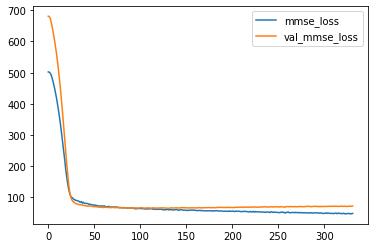

In [14]:
metrics = history.history
plt.plot(history.epoch, metrics['mmse_loss'], metrics['val_mmse_loss'])
plt.legend(['mmse_loss', 'val_mmse_loss'])
plt.show()

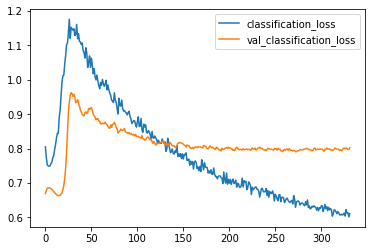

In [15]:
metrics = history.history
plt.plot(history.epoch, metrics['classification_loss'], metrics['val_classification_loss'])
plt.legend(['classification_loss', 'val_classification_loss'])
plt.show()

In [16]:
np.sqrt(model.evaluate(val_ds.batch(BATCH_SIZE))[1])

18/18 [==============================] - 0s 11ms/step - loss: 4.4131 - mmse_loss: 73.0217 - classification_loss: 0.8021


8.545271644627148

In [17]:
np.sqrt(model.evaluate(test_ds.batch(BATCH_SIZE))[1])

20/20 [==============================] - 1s 38ms/step - loss: 3.3686 - mmse_loss: 56.1285 - classification_loss: 0.5918


7.491897784251195

In [18]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.split("/")[-1].split(".")[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(getData(file)[0])
    
    avg_predict = np.mean(predict[0])
    std_predict = np.std(predict[0])
    
    avg_predict_group_prob = np.mean(predict[1][:,0])
    std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse'] = avg_predict
    meta.loc[meta["ID"]==id,'predict_mmse_std'] = std_predict
    meta.loc[meta["ID"]==id,'predict_group_prob'] = avg_predict_group_prob
    meta.loc[meta["ID"]==id,'predict_group_prob_std'] = std_predict_group_prob


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")
    

In [19]:
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.828052
1,train,5.485420
2,val,7.990960


In [20]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,6.511171
1,male,5.640780


In [21]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse'] ))

6.139583012559549

In [22]:
meta["predict_mmse_std_min"] = meta["predict_mmse"] - meta["predict_mmse_std"]
meta["predict_mmse_std_max"] = meta["predict_mmse"] + meta["predict_mmse_std"]

In [23]:
meta

,index,ID,Age,Gender,MMSE,Group,split,predict_mmse,predict_group_prob,predict_mmse_std,predict_group_prob_std,predict_mmse_std_min,predict_mmse_std_max
0,0,S001,74,male,30,cc,train,25.269573,0.352080,3.332415,0.202972,21.937158,28.601988
1,1,S002,62,female,30,cc,train,22.336296,0.623580,2.937043,0.147785,19.399253,25.273340
2,2,S003,69,female,29,cc,val,20.867971,0.533835,3.493295,0.204823,17.374677,24.361266
3,3,S004,71,female,30,cc,train,22.063463,0.507745,3.880831,0.223384,18.182633,25.944294
4,4,S005,74,female,30,cc,train,22.663578,0.533869,2.825546,0.131588,19.838032,25.489124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,train,22.025188,0.296912,1.799867,0.133124,20.225321,23.825056
104,50,S151,72,male,24,cd,train,21.815302,0.452249,3.401550,0.191469,18.413752,25.216852
105,51,S153,68,female,12,cd,train,17.967852,0.605640,2.743010,0.143605,15.224841,20.710862
106,52,S154,65,female,20,cd,test,19.200191,0.570633,2.884841,0.127689,16.315351,22.085032


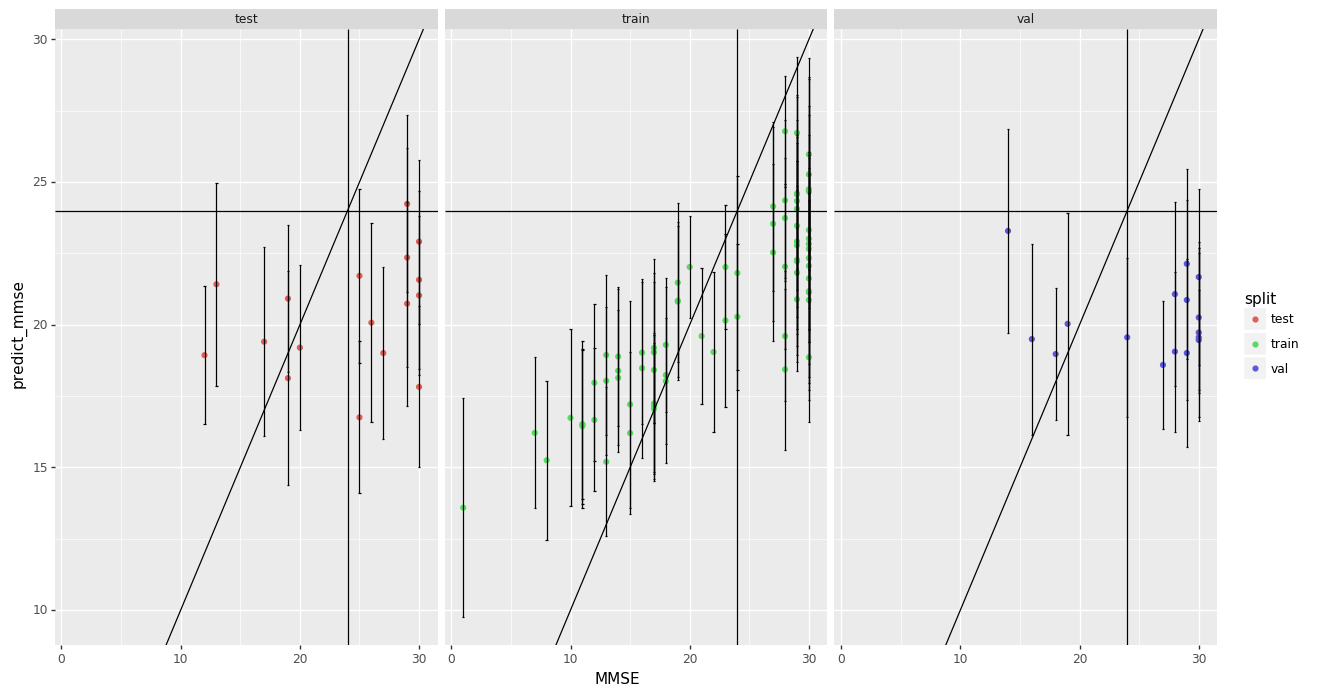

<ggplot: (8791374543101)>

In [24]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse', colour = 'split')) + \
geom_errorbar(aes(x='MMSE', ymin='predict_mmse_std_min', ymax='predict_mmse_std_max'), width=.2) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

Logistic: ROC AUC = 0.872


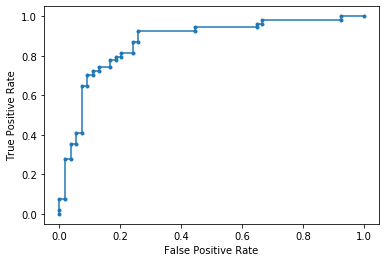

In [25]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()